In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Cell 1: Imports & reproducibility
import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm
import torch, cv2
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from skimage.feature import local_binary_pattern
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import cifar10

# Reproducible & device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

ngpu = torch.cuda.device_count()
device = torch.device("cuda" if ngpu>0 else "cpu")
print(f"Device: {device}, GPUs: {ngpu}")


2025-04-24 18:17:50.495677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745518670.757248      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745518670.837074      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda, GPUs: 2


In [ ]:
# ─── Traditional BoW Pipeline ────────────────────────────────────────────────

# Cell 2: Load & subsample CIFAR-10
(Xtr, ytr), (Xte, yte) = cifar10.load_data()
X_all = np.concatenate((Xtr, Xte))
y_all = np.concatenate((ytr, yte)).flatten()
idx = np.random.RandomState(SEED).choice(len(X_all), 15000, replace=False)
X_sub, y_sub = X_all[idx], y_all[idx]
print("Subsampled:", X_sub.shape, y_sub.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Subsampled: (15000, 32, 32, 3) (15000,)


In [ ]:
# Cell 3: BoW feature extraction & preprocessing
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    cl = cv2.createCLAHE(2.0,(8,8)).apply(gray)
    return cv2.resize(cl,(128,128))

X_gray = [preprocess(im) for im in tqdm(X_sub, desc="Preprocessing")]

sift = cv2.SIFT_create()
def dense_sift(img, step=8, scales=(8,16)):
    kps = [
        cv2.KeyPoint(x,y,sc)
        for sc in scales
        for y in range(sc//2, img.shape[0], step)
        for x in range(sc//2, img.shape[1], step)
    ]
    _, des = sift.compute(img, kps)
    return des

desc_map, all_desc = [], []
for img in tqdm(X_gray, desc="Dense SIFT"):
    des = dense_sift(img)
    if des is None:
        desc_map.append(np.zeros((0,128),dtype=np.float32))
    else:
        d = des.astype(np.float32)
        d /= (d.sum(axis=1,keepdims=True)+1e-7)
        desc_map.append(d)
        all_desc.append(d)
all_desc = np.vstack(all_desc)
np.random.shuffle(all_desc)
all_desc = all_desc[:200_000]

def extract_lbp(img, P=8, R=1):
    lbp = local_binary_pattern(img, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0,P+3), range=(0,P+2))
    return hist.astype(float)/(hist.sum()+1e-6)

lbp_feats = np.array([extract_lbp(im) for im in tqdm(X_gray, desc="LBP")])

def color_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv],[0,1],None,[32,32],[0,180,0,256])
    return cv2.normalize(hist,hist).flatten()

color_feats = np.array([
    color_hist(cv2.resize(im,(128,128))) for im in tqdm(X_sub, desc="Color Hist")
])


Color Hist: 100%|██████████| 15000/15000 [00:02<00:00, 5312.33it/s]


In [ ]:
# Cell 4: BoW Random Search (k, C, γ)
from sklearn.svm import SVC
import random

bow_param_grid = {'k':[64,128,256], 'C':[1,10,100], 'gamma':[1e-3,1e-4]}
all_bow = list(ParameterGrid(bow_param_grid))
random.shuffle(all_bow)
sampled_bow = all_bow[:6]  # sample 6 settings

bow_results = []
for params in sampled_bow:
    k, C, gamma = params['k'], params['C'], params['gamma']

    # vocabulary
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=5000, random_state=SEED)
    kmeans.fit(all_desc)

    # encoding
    H = np.zeros((len(X_gray),k),dtype=np.float32)
    for i,des in enumerate(desc_map):
        if des.size:
            w = kmeans.predict(des)
            H[i],_ = np.histogram(w,bins=np.arange(k+1))

    feats = np.hstack([H, lbp_feats, color_feats])
    feats = StandardScaler().fit_transform(feats)
    feats = PCA(n_components=150, random_state=SEED).fit_transform(feats)

    Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
        feats, y_sub, test_size=0.2, stratify=y_sub, random_state=SEED
    )
    svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=SEED).fit(Xtr_b, ytr_b)
    acc = accuracy_score(yte_b, svm.predict(Xte_b))

    bow_results.append({'k':k,'C':C,'gamma':gamma,'acc':acc})

bow_df = pd.DataFrame(bow_results).sort_values('acc', ascending=False)
bow_df.to_csv("bow_random_search_results.csv", index=False)
print(bow_df)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: 

     k    C   gamma       acc
5  128   10  0.0010  0.457333
4  256    1  0.0001  0.447667
0  128  100  0.0010  0.427667
2  128    1  0.0001  0.421667
3   64   10  0.0001  0.418000
1   64  100  0.0010  0.405667


Best BoW params: {'k': 128.0, 'C': 10.0, 'gamma': 0.001, 'acc': 0.4573333333333333}
Refitting with k=128, C=10.0, gamma=0.001


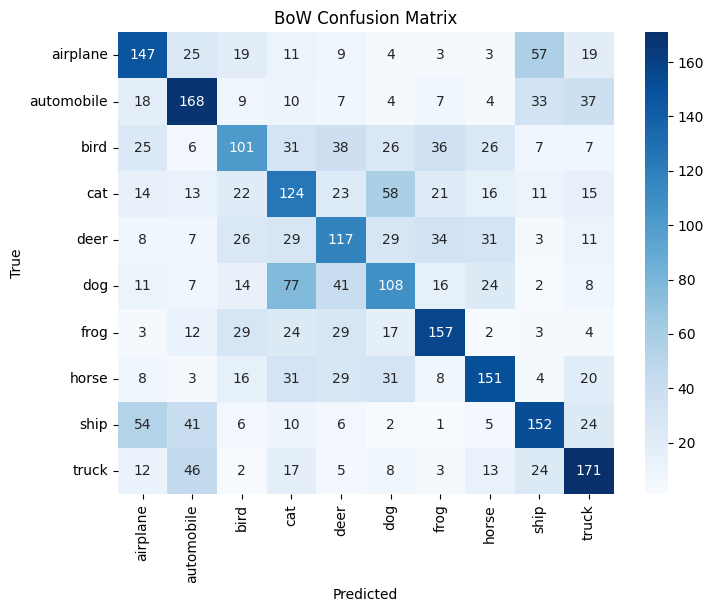

              precision    recall  f1-score   support

    airplane       0.49      0.49      0.49       297
  automobile       0.51      0.57      0.54       297
        bird       0.41      0.33      0.37       303
         cat       0.34      0.39      0.36       317
        deer       0.38      0.40      0.39       295
         dog       0.38      0.35      0.36       308
        frog       0.55      0.56      0.55       280
       horse       0.55      0.50      0.52       301
        ship       0.51      0.50      0.51       301
       truck       0.54      0.57      0.55       301

    accuracy                           0.47      3000
   macro avg       0.47      0.47      0.47      3000
weighted avg       0.47      0.47      0.46      3000



In [ ]:
# Cell 5 (fixed): BoW Evaluation & Confusion Matrix
import seaborn as sns

# CIFAR-10 class labels
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

best_bow = bow_df.iloc[0]
print("Best BoW params:", best_bow.to_dict())

# Cast params to correct types
k     = int(best_bow['k'])
C     = float(best_bow['C'])
gamma = float(best_bow['gamma'])

print(f"Refitting with k={k}, C={C}, gamma={gamma}")

# Rebuild vocabulary (with explicit n_init to avoid warning)
kmeans = MiniBatchKMeans(
    n_clusters=k,
    batch_size=5000,
    random_state=SEED,
    n_init=10
).fit(all_desc)

# Encode features
H = np.zeros((len(X_gray), k), dtype=np.float32)
for i, des in enumerate(desc_map):
    if des.size:
        words = kmeans.predict(des)
        H[i], _ = np.histogram(words, bins=np.arange(k+1))

# Combine, scale, PCA
feats = np.hstack([H, lbp_feats, color_feats])
feats = StandardScaler().fit_transform(feats)
feats = PCA(n_components=150, random_state=SEED).fit_transform(feats)

# Split & train SVM
Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
    feats, y_sub, test_size=0.2, stratify=y_sub, random_state=SEED
)
svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=SEED).fit(Xtr_b, ytr_b)

# Predict & plot confusion matrix
preds = svm.predict(Xte_b)
cm = confusion_matrix(yte_b, preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.title("BoW Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(yte_b, preds, target_names=class_names))


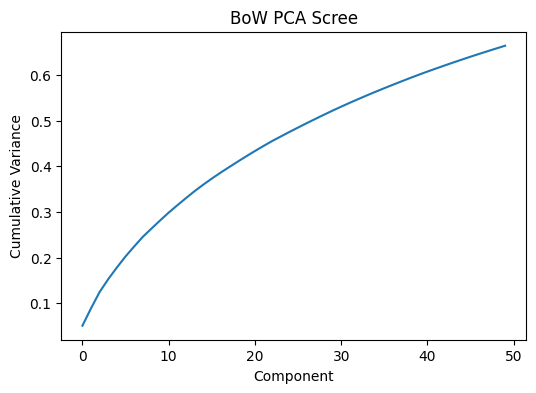

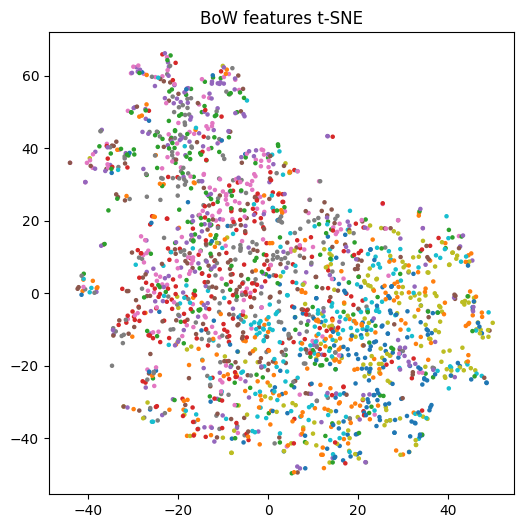

In [ ]:
# Cell 6: BoW PCA Scree & t-SNE
# Scree plot
pca_full = PCA().fit(feats)
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)[:50])
plt.xlabel("Component"); plt.ylabel("Cumulative Variance")
plt.title("BoW PCA Scree"); plt.show()

# t-SNE (subset 2k points)
idx2 = np.random.RandomState(SEED).choice(len(feats), 2000, replace=False)
fs, ls = feats[idx2], y_sub[idx2]
tsne = TSNE(n_components=2, random_state=SEED)
fs2 = tsne.fit_transform(fs)
plt.figure(figsize=(6,6))
plt.scatter(fs2[:,0], fs2[:,1], c=ls, cmap='tab10', s=5)
plt.title("BoW features t-SNE"); plt.show()


In [ ]:
# ─── CNN Pipeline ───────────────────────────────────────────────────────────

# Cell 7: CNN data transforms & loaders
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)
train_tf = T.Compose([
    T.RandomCrop(32,padding=4), T.RandomHorizontalFlip(),
    T.RandomRotation(15), T.ToTensor(), T.Normalize(mean,std)
])
val_tf = T.Compose([T.ToTensor(), T.Normalize(mean,std)])

bs = 128
train_ds = torchvision.datasets.CIFAR10('./data', train=True,  download=True, transform=train_tf)
val_ds   = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
classes = train_ds.classes
print(f"Loaders: {len(train_loader)} train batches, {len(val_loader)} val batches")


100%|██████████| 170M/170M [00:03<00:00, 56.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Loaders: 391 train batches, 79 val batches


In [ ]:
# Cell 8: Define ResidualBlock & EnhancedCustomCNN
class ResidualBlock(nn.Module):
    def __init__(self,in_c,out_c,stride=1):
        super().__init__()
        self.conv1=nn.Conv2d(in_c,out_c,3,stride,1,bias=False)
        self.bn1  =nn.BatchNorm2d(out_c)
        self.conv2=nn.Conv2d(out_c,out_c,3,1,1,bias=False)
        self.bn2  =nn.BatchNorm2d(out_c)
        self.relu =nn.ReLU(inplace=True)
        self.down =(nn.Sequential(
                        nn.Conv2d(in_c,out_c,1,stride,bias=False),
                        nn.BatchNorm2d(out_c))
                    if (stride!=1 or in_c!=out_c) else None)
    def forward(self,x):
        idt=x
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        if self.down: idt=self.down(x)
        out+=idt; return self.relu(out)

class EnhancedCustomCNN(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.stem=nn.Sequential(
            nn.Conv2d(3,64,3,1,1,bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.layer1=self._make_stage(64,128,2,1)
        self.layer2=self._make_stage(128,256,2,2)
        self.layer3=self._make_stage(256,512,2,2)
        self.pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Sequential(
            nn.Flatten(), nn.Dropout(0.5),
            nn.Linear(512,256), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(256,num_classes)
        )
    def _make_stage(self,in_c,out_c,blocks,stride):
        layers=[ResidualBlock(in_c,out_c,stride)]
        for _ in range(1,blocks): layers.append(ResidualBlock(out_c,out_c))
        return nn.Sequential(*layers)
    def forward(self,x):
        x=self.stem(x); x=self.layer1(x); x=self.layer2(x)
        x=self.layer3(x); x=self.pool(x)
        return self.fc(x)


In [ ]:
# Cell 9: train/eval functions
def train_epoch(m,loader,opt,crit):
    m.train(); loss_tot=correct=total=0
    for x,y in loader:
        x,y=x.to(device),y.to(device)
        opt.zero_grad()
        out=m(x); loss=crit(out,y)
        loss.backward(); opt.step()
        loss_tot+=loss.item()*x.size(0)
        correct+=out.argmax(1).eq(y).sum().item()
        total+=x.size(0)
    return loss_tot/total, correct/total

def eval_epoch(m,loader,crit):
    m.eval(); loss_tot=correct=total=0
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            out=m(x); loss=crit(out,y)
            loss_tot+=loss.item()*x.size(0)
            correct+=out.argmax(1).eq(y).sum().item()
            total+=x.size(0)
    return loss_tot/total, correct/total


In [ ]:
# Cell 10: CNN Random Search (lr, weight_decay)
import random
cnn_params = {'lr':[1e-2,1e-3,5e-4], 'weight_decay':[1e-3,5e-4,1e-4]}
all_cnn = list(product(cnn_params['lr'], cnn_params['weight_decay']))
random.shuffle(all_cnn)
sampled_cnn = all_cnn[:4]  # try 4 combos
cnn_results=[]
num_epochs=20

for lr,wd in sampled_cnn:
    m = EnhancedCustomCNN(len(classes))
    if ngpu>1: m=nn.DataParallel(m)
    m=m.to(device)
    crit=nn.CrossEntropyLoss(label_smoothing=0.1)
    opt=optim.AdamW(m.parameters(), lr=lr, weight_decay=wd)
    sched=optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)
    hist={'val_acc':[]}
    for _ in range(num_epochs):
        train_epoch(m, train_loader, opt, crit)
        _,acc=eval_epoch(m, val_loader, crit)
        hist['val_acc'].append(acc)
        sched.step()
    cnn_results.append({'lr':lr,'weight_decay':wd,'best_val_acc':max(hist['val_acc'])})

cnn_df = pd.DataFrame(cnn_results).sort_values('best_val_acc', ascending=False)
cnn_df.to_csv("cnn_random_search_results.csv", index=False)
print(cnn_df)


       lr  weight_decay  best_val_acc
3  0.0005        0.0005        0.9071
0  0.0100        0.0001        0.8820
1  0.0100        0.0005        0.8785
2  0.0100        0.0010        0.8710


In [ ]:
# Cell 11: Retrain Best CNN (30 epochs) & save
best = cnn_df.iloc[0]
print("Best CNN params:", best.to_dict())

model = EnhancedCustomCNN(len(classes))
if ngpu>1: model=nn.DataParallel(model)
model=model.to(device)
crit=nn.CrossEntropyLoss(label_smoothing=0.1)
opt=optim.AdamW(model.parameters(), lr=best.lr, weight_decay=best.weight_decay)
sched=optim.lr_scheduler.CosineAnnealingLR(opt, T_max=30)

hist={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
for e in range(1,31):
    tl,ta = train_epoch(model, train_loader, opt, crit)
    vl,va = eval_epoch(model, val_loader, crit)
    sched.step()
    hist['train_loss'].append(tl); hist['train_acc'].append(ta)
    hist['val_loss'].append(vl);   hist['val_acc'].append(va)
    print(f"Epoch {e}/30 — Train: {tl:.3f},{ta:.3f} | Val: {vl:.3f},{va:.3f}")

torch.save(model.state_dict(), "best_cnn.pth")


Best CNN params: {'lr': 0.0005, 'weight_decay': 0.0005, 'best_val_acc': 0.9071}
Epoch 1/30 — Train: 1.782,0.394 | Val: 1.666,0.466
Epoch 2/30 — Train: 1.484,0.559 | Val: 1.632,0.503
Epoch 3/30 — Train: 1.349,0.627 | Val: 1.393,0.612
Epoch 4/30 — Train: 1.254,0.674 | Val: 1.207,0.697
Epoch 5/30 — Train: 1.160,0.722 | Val: 1.132,0.731
Epoch 6/30 — Train: 1.089,0.758 | Val: 0.979,0.800
Epoch 7/30 — Train: 1.042,0.778 | Val: 0.982,0.796
Epoch 8/30 — Train: 0.994,0.800 | Val: 1.020,0.790
Epoch 9/30 — Train: 0.958,0.819 | Val: 0.912,0.827
Epoch 10/30 — Train: 0.928,0.831 | Val: 0.882,0.842
Epoch 11/30 — Train: 0.899,0.843 | Val: 0.863,0.848
Epoch 12/30 — Train: 0.877,0.853 | Val: 0.816,0.873
Epoch 13/30 — Train: 0.850,0.865 | Val: 0.820,0.867
Epoch 14/30 — Train: 0.831,0.873 | Val: 0.810,0.876
Epoch 15/30 — Train: 0.814,0.881 | Val: 0.772,0.890
Epoch 16/30 — Train: 0.792,0.891 | Val: 0.803,0.875
Epoch 17/30 — Train: 0.776,0.897 | Val: 0.777,0.887
Epoch 18/30 — Train: 0.755,0.905 | Val: 0.744

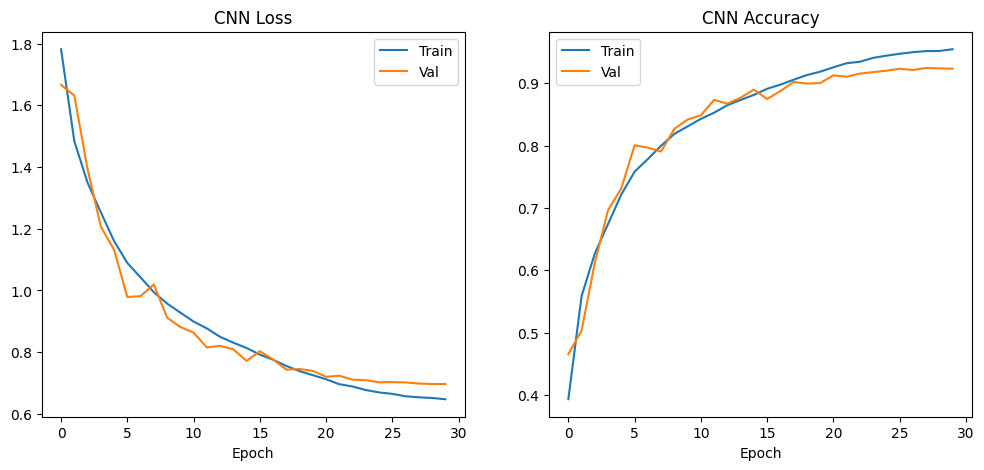

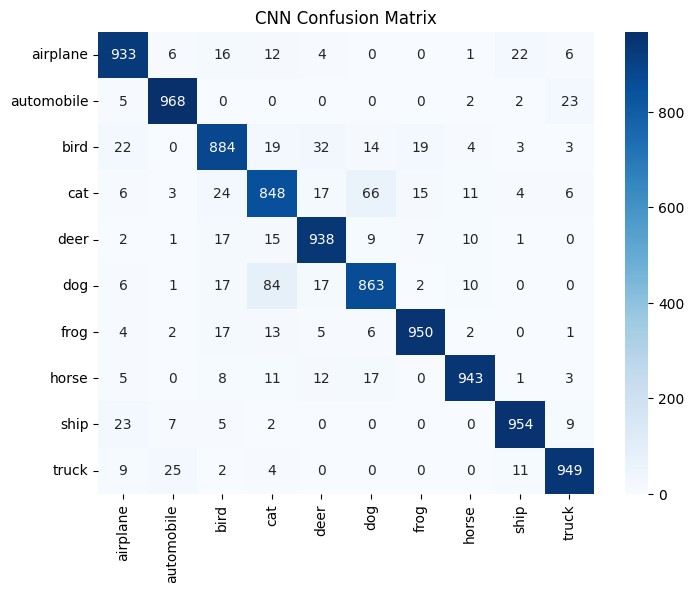

              precision    recall  f1-score   support

    airplane       0.92      0.93      0.93      1000
  automobile       0.96      0.97      0.96      1000
        bird       0.89      0.88      0.89      1000
         cat       0.84      0.85      0.84      1000
        deer       0.92      0.94      0.93      1000
         dog       0.89      0.86      0.87      1000
        frog       0.96      0.95      0.95      1000
       horse       0.96      0.94      0.95      1000
        ship       0.96      0.95      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



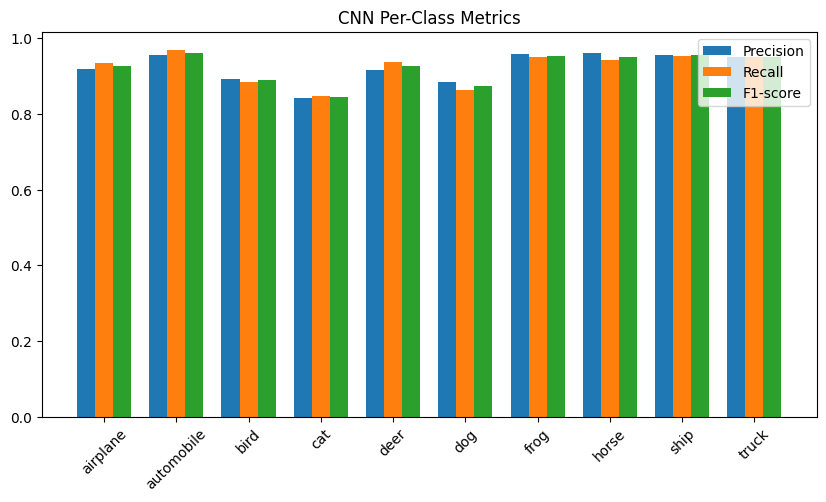

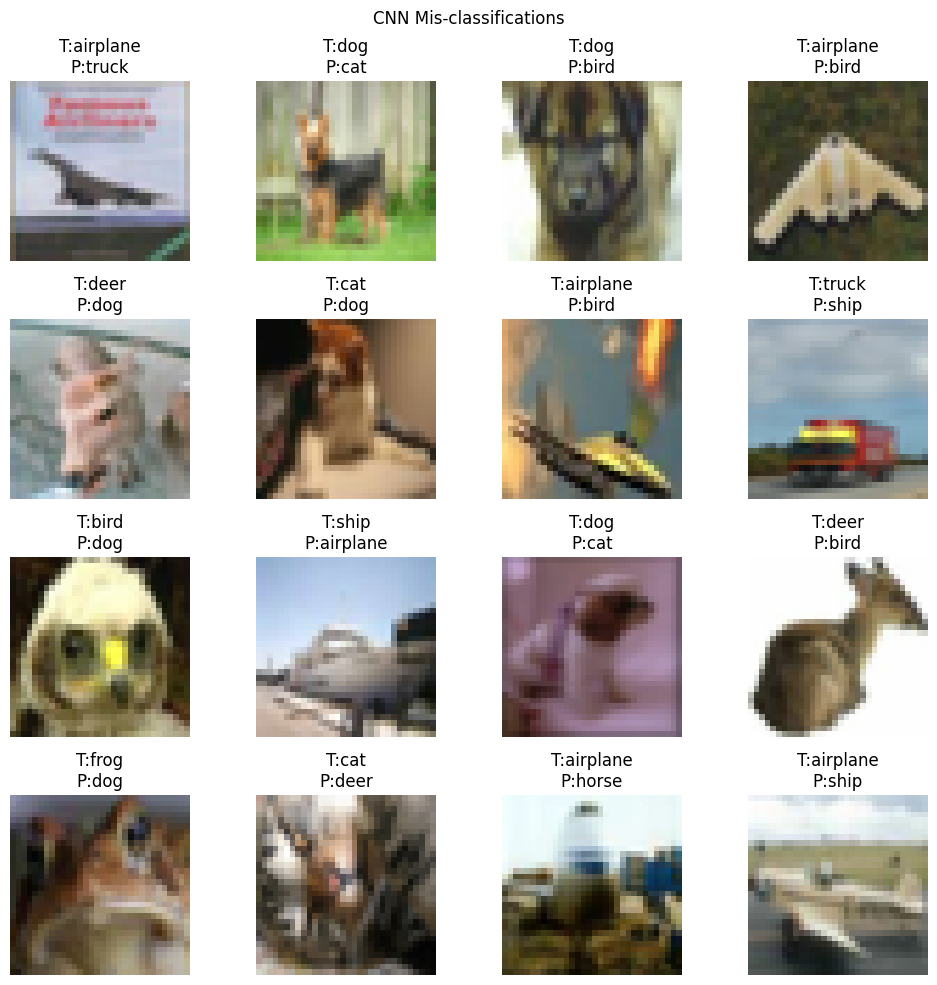

In [ ]:
# Cell 12: CNN Evaluation & Visualizations
# Learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist['train_loss'], label='Train'); plt.plot(hist['val_loss'], label='Val')
plt.title("CNN Loss"); plt.xlabel("Epoch"); plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['train_acc'], label='Train'); plt.plot(hist['val_acc'], label='Val')
plt.title("CNN Accuracy"); plt.xlabel("Epoch"); plt.legend()
plt.show()

# Confusion matrix & report
model.eval(); preds=[]; labs=[]
with torch.no_grad():
    for x,y in val_loader:
        p=model(x.to(device)).argmax(1).cpu().numpy()
        preds.extend(p); labs.extend(y.numpy())
cm = confusion_matrix(labs, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("CNN Confusion Matrix"); plt.show()
print(classification_report(labs, preds, target_names=classes))

# Per-class metrics
prec,rec,f1,_ = precision_recall_fscore_support(labs, preds, average=None)
x = np.arange(len(classes)); w=0.25
plt.figure(figsize=(10,5))
plt.bar(x-w, prec, w, label='Precision')
plt.bar(x,    rec, w, label='Recall')
plt.bar(x+w,  f1,  w, label='F1-score')
plt.xticks(x, classes, rotation=45); plt.title("CNN Per-Class Metrics"); plt.legend(); plt.show()

# Mis-classification montage
mis=[]
with torch.no_grad():
    for x,y in val_loader:
        out=model(x.to(device)).argmax(1).cpu().numpy()
        for im_n, lbl, pr in zip(x, y.numpy(), out):
            if lbl!=pr and len(mis)<16:
                img = im_n.permute(1,2,0).numpy()
                img = (img*std + mean).clip(0,1)
                mis.append((img, lbl, pr))
        if len(mis)>=16: break

plt.figure(figsize=(10,10))
for i,(img,l,p) in enumerate(mis):
    ax=plt.subplot(4,4,i+1)
    ax.imshow(img); ax.set_title(f"T:{classes[l]}\nP:{classes[p]}"); ax.axis('off')
plt.suptitle("CNN Mis-classifications"); plt.tight_layout(); plt.show()


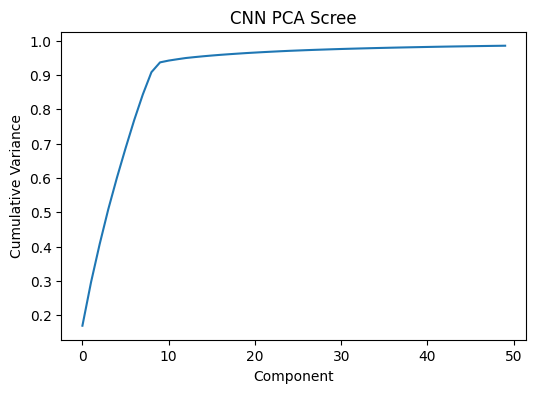

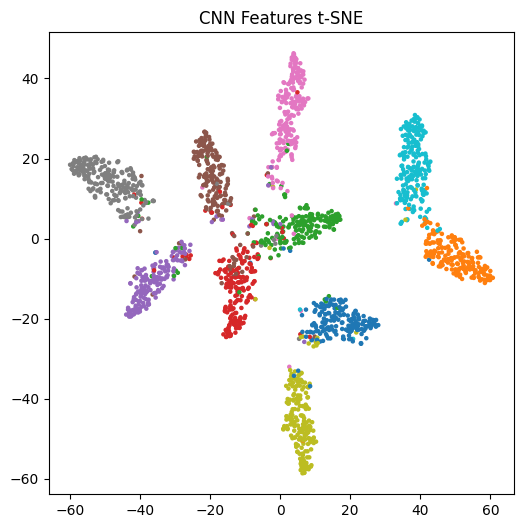

In [ ]:
# Cell 13: CNN PCA Scree & t-SNE on penultimate features
# extract penultimate feats
base = model.module if isinstance(model, nn.DataParallel) else model
feat_extractor = nn.Sequential(base.stem, base.layer1, base.layer2, base.layer3, base.pool).to(device)
feats_c, labs_c = [], []
with torch.no_grad():
    for x,y in val_loader:
        out = feat_extractor(x.to(device)).view(x.size(0),-1).cpu().numpy()
        feats_c.append(out); labs_c.extend(y.numpy())
feats_c = np.vstack(feats_c); labs_c = np.array(labs_c)

# Scree
pca_c = PCA().fit(feats_c)
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_c.explained_variance_ratio_)[:50])
plt.xlabel("Component"); plt.ylabel("Cumulative Variance")
plt.title("CNN PCA Scree"); plt.show()

# t-SNE (2k subset)
idx_c = np.random.RandomState(SEED).choice(len(feats_c),2000,replace=False)
f_c2, l_c2 = feats_c[idx_c], labs_c[idx_c]
tsne_c = TSNE(n_components=2, random_state=SEED)
f2_c = tsne_c.fit_transform(f_c2)
plt.figure(figsize=(6,6))
plt.scatter(f2_c[:,0], f2_c[:,1], c=l_c2, cmap='tab10', s=5)
plt.title("CNN Features t-SNE"); plt.show()


CNN parameter count: 11,154,762
BoW vocabulary size (k): 128
Avg BoW feature time: 0.04183465361595154 s/image
KMeans fit time: 8.891451597213745 s
CNN train‐epoch time: 61.26211428642273 s


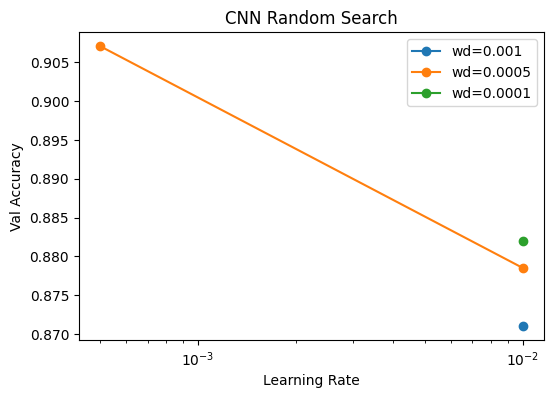

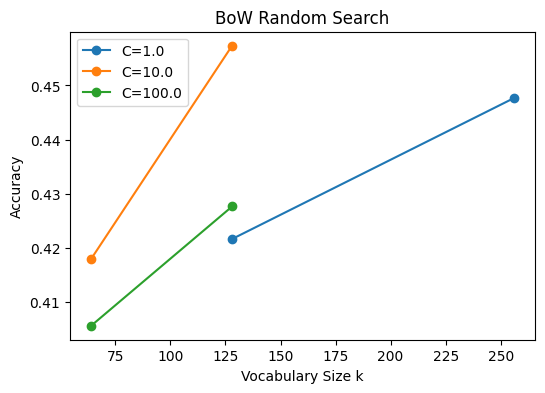

In [ ]:
# Cell 14: Model complexity, timing benchmarks & hyperparameter‐performance plots

import time

# 15.1 Model complexity
cnn_param_count = sum(p.numel() for p in model.parameters())
print(f"CNN parameter count: {cnn_param_count:,}")
print(f"BoW vocabulary size (k): {k}")

# 15.2 Timing benchmarks
n = 200
#  – BoW feature‐extraction
start = time.time()
for img in X_sub[:n]:
    p_gray = preprocess(img)
    _ = extract_lbp(p_gray)
    _ = dense_sift(p_gray)
    p_color = cv2.resize(img, (128,128))
    _ = color_hist(p_color)
print("Avg BoW feature time:", (time.time()-start)/n, "s/image")

#  – K-means clustering
start = time.time()
_ = MiniBatchKMeans(n_clusters=k, batch_size=5000, random_state=SEED, n_init=10).fit(all_desc)
print("KMeans fit time:", time.time()-start, "s")

#  – CNN train‐epoch
tmp = EnhancedCustomCNN(len(classes)).to(device)
if ngpu>1: tmp=nn.DataParallel(tmp)
opt_tmp = optim.AdamW(tmp.parameters(), lr=1e-3, weight_decay=5e-4)
crit_tmp = nn.CrossEntropyLoss(label_smoothing=0.1)
start = time.time()
_ = train_epoch(tmp, train_loader, opt_tmp, crit_tmp)
print("CNN train‐epoch time:", time.time()-start, "s")

# 15.3 Hyper‐parameter scatter (CNN)
plt.figure(figsize=(6,4))
for wd in cnn_params['weight_decay']:
    df = cnn_df[cnn_df['weight_decay']==wd]
    plt.plot(df['lr'], df['best_val_acc'], '-o', label=f'wd={wd}')
plt.xscale('log'); plt.xlabel('Learning Rate'); plt.ylabel('Val Accuracy')
plt.title('CNN Random Search'); plt.legend(); plt.show()

# 15.4 Hyper‐parameter scatter (BoW)
plt.figure(figsize=(6,4))
for C_val in sorted(bow_df['C'].astype(float).unique()):
    df = bow_df[bow_df['C']==C_val]
    plt.plot(df['k'], df['acc'], '-o', label=f'C={C_val}')
plt.xlabel('Vocabulary Size k'); plt.ylabel('Accuracy')
plt.title('BoW Random Search'); plt.legend(); plt.show()


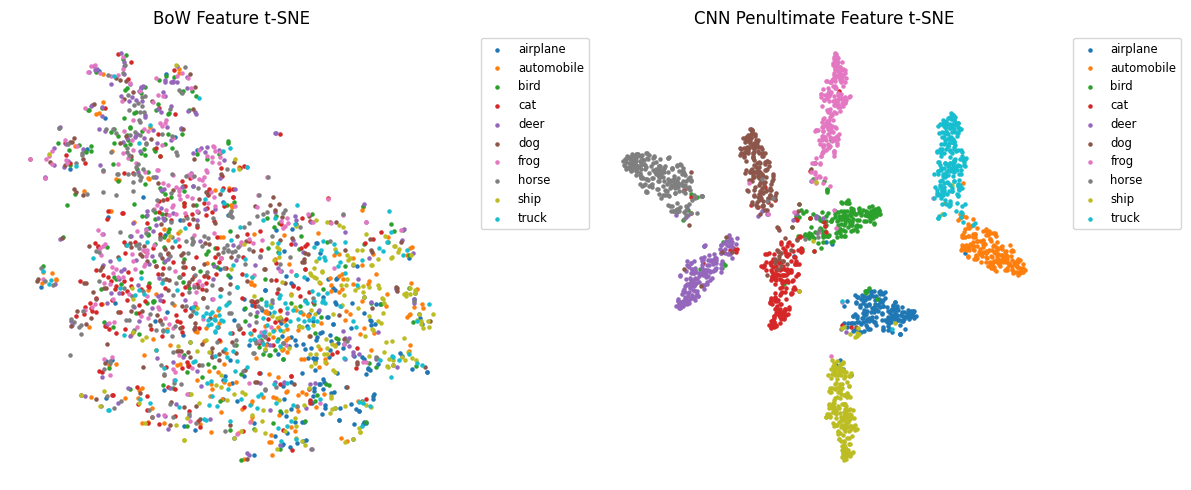

In [ ]:
# Cell 15: Side-by-side t-SNE of BoW vs CNN feature spaces with class legends

from sklearn.manifold import TSNE

# CIFAR-10 class names (ensure this matches your earlier definition)
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 1) Compute 2-D t-SNE for subsets
n_pts = 2000
idx_bo  = np.random.RandomState(SEED).choice(len(feats),   n_pts, replace=False)
idx_cnn = np.random.RandomState(SEED).choice(len(feats_c), n_pts, replace=False)

X_bo,  y_bo  = feats[idx_bo],  y_sub[idx_bo]
X_cnn2, y_cnn2 = feats_c[idx_cnn], labs_c[idx_cnn]

tsne = TSNE(n_components=2, random_state=SEED)

Z_bo  = tsne.fit_transform(X_bo)
Z_cnn = tsne.fit_transform(X_cnn2)

# 2) Plot side-by-side with legends
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for i, cls in enumerate(class_names):
    mask = (y_bo == i)
    plt.scatter(Z_bo[mask,0], Z_bo[mask,1], s=5, label=cls)
plt.title("BoW Feature t-SNE")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.axis("off")

plt.subplot(1,2,2)
for i, cls in enumerate(class_names):
    mask = (y_cnn2 == i)
    plt.scatter(Z_cnn[mask,0], Z_cnn[mask,1], s=5, label=cls)
plt.title("CNN Penultimate Feature t-SNE")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.axis("off")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


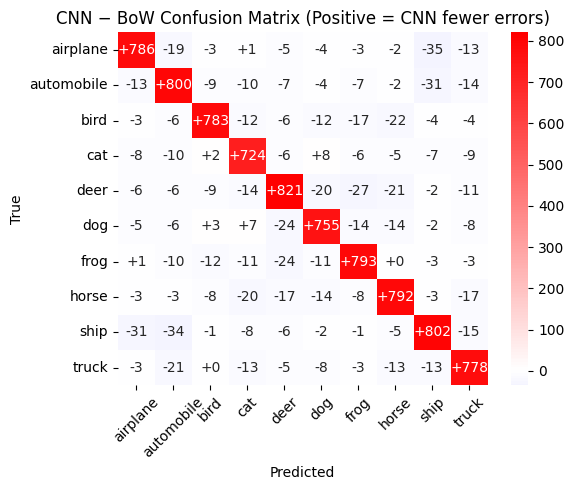

In [ ]:
# Cell 17: Confusion‐Matrix Difference Heatmap

from sklearn.metrics import confusion_matrix

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 1) BoW confusion matrix (using previously computed Xte_b, yte_b and svm)
preds_bow = svm.predict(Xte_b)
cm_bow = confusion_matrix(yte_b, preds_bow)

# 2) CNN confusion matrix (evaluate the best CNN 'model' on val_loader)
model.eval()
all_preds_cnn = []
all_true_cnn  = []

with torch.no_grad():
    for x, y in val_loader:
        outputs = model(x.to(device))
        preds   = outputs.argmax(1).cpu().numpy()
        all_preds_cnn.extend(preds)
        all_true_cnn.extend(y.numpy())

cm_cnn = confusion_matrix(all_true_cnn, all_preds_cnn)

# 3) Difference (CNN − BoW)
diff_cm = cm_cnn - cm_bow

# 4) Plot heatmap of differences
plt.figure(figsize=(6,5))
sns.heatmap(
    diff_cm,
    annot=True,
    fmt='+d',
    cmap='bwr',
    center=0,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('CNN − BoW Confusion Matrix (Positive = CNN fewer errors)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
